## Customer Segmentation Project – Bank Transactions Dataset

   Goal: Build a scalable, end-to-end customer segmentation pipeline using transactional data, combining ML-based clustering       techniques with traditional RFM analysis for business-driven insights.

#  Importing Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

%matplotlib inline
sns.set(style="whitegrid")

#  Load Data

In [50]:
df = pd.read_csv(r'/content/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207.0,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858.0,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712.0,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714.0,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156.0,1762.5


# Data Understanding

In [51]:
df.shape

(295762, 9)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295762 entries, 0 to 295761
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   TransactionID            295762 non-null  object 
 1   CustomerID               295761 non-null  object 
 2   CustomerDOB              294812 non-null  object 
 3   CustGender               295450 non-null  object 
 4   CustLocation             295709 non-null  object 
 5   CustAccountBalance       294959 non-null  float64
 6   TransactionDate          295761 non-null  object 
 7   TransactionTime          295761 non-null  float64
 8   TransactionAmount (INR)  295761 non-null  float64
dtypes: float64(3), object(6)
memory usage: 20.3+ MB


In [53]:
df.describe(include='all')

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
count,295762,295761,294812,295450,295709,2.949590e+05,295761,295761.000000,295761.000000
unique,295761,281376,14578,2,6341,NaN,40,NaN,NaN
top,T2,C1440911,1/1/1800,M,MUMBAI,NaN,7/8/16,NaN,NaN
freq,2,4,16029,215059,29171,NaN,27256,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.088232e+05,NaN,156780.467097,1593.723738
std,NaN,NaN,NaN,NaN,NaN,6.940570e+05,NaN,50637.775030,6237.757377
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,1.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,4.517160e+03,NaN,124615.000000,169.000000
50%,NaN,NaN,NaN,NaN,NaN,1.603607e+04,NaN,163250.000000,470.000000
75%,NaN,NaN,NaN,NaN,NaN,5.478287e+04,NaN,195702.000000,1200.000000


In [54]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

TransactionID: 295761 unique values
CustomerID: 281376 unique values
CustomerDOB: 14578 unique values
CustGender: 2 unique values
CustLocation: 6341 unique values
CustAccountBalance: 98442 unique values
TransactionDate: 40 unique values
TransactionTime: 69632 unique values
TransactionAmount (INR): 37533 unique values


In [55]:
df.isnull().sum()

,0
TransactionID,0
CustomerID,1
CustomerDOB,950
CustGender,312
CustLocation,53
CustAccountBalance,803
TransactionDate,1
TransactionTime,1
TransactionAmount (INR),1


In [56]:
df.duplicated().sum()

np.int64(0)

# Exploratory Data Analysis (EDA) – Visualization

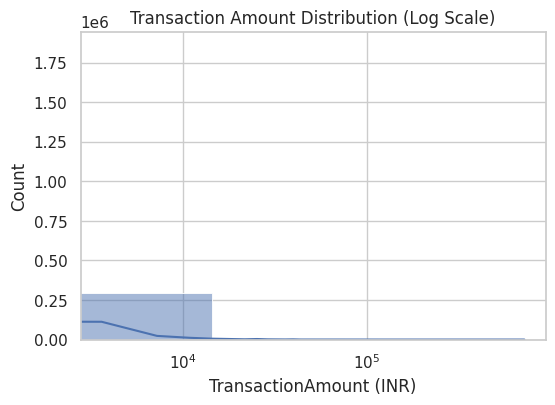

In [57]:
plt.figure(figsize=(6,4))
sns.histplot(df['TransactionAmount (INR)'], bins=50, kde=True)
plt.xscale('log')
plt.title('Transaction Amount Distribution (Log Scale)')
plt.show()

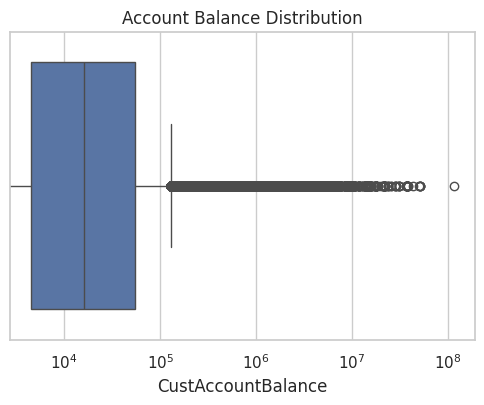

In [58]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['CustAccountBalance'])
plt.xscale('log')
plt.title('Account Balance Distribution')
plt.show()

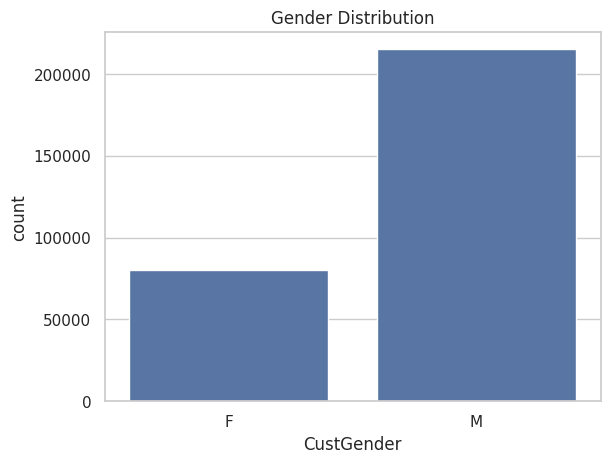

In [59]:
sns.countplot(x='CustGender', data=df)
plt.title('Gender Distribution')
plt.show()

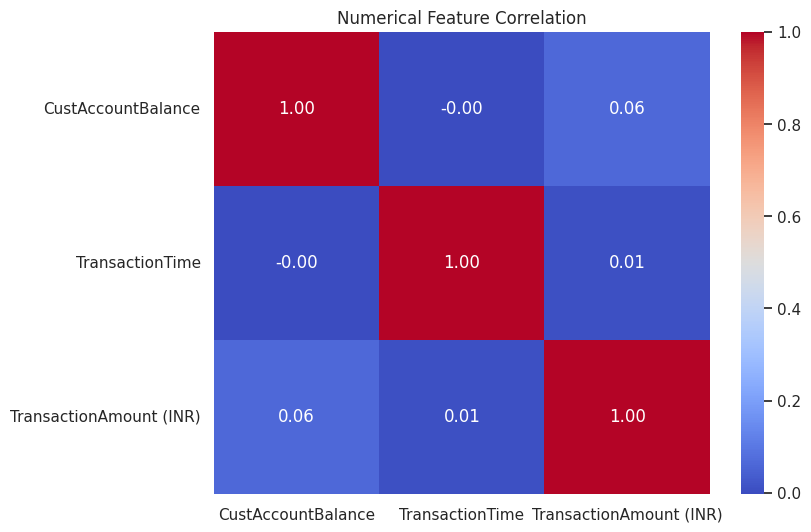

In [60]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df.select_dtypes(include=np.number).corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".2f"
)
plt.title('Numerical Feature Correlation')
plt.show()

# Data Cleaning

In [61]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], dayfirst=True, errors='coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True, errors='coerce')

/tmp/ipython-input-2777776080.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], dayfirst=True, errors='coerce')
/tmp/ipython-input-2777776080.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True, errors='coerce')


In [62]:
reference_date = df['TransactionDate'].max()
df['Age'] = (reference_date - df['CustomerDOB']).dt.days // 365

In [63]:
df['Age'].describe()

,Age
count,294812.000000
mean,29.983868
std,51.157225
min,-60.000000
25%,24.000000
50%,27.000000
75%,32.000000
max,216.000000


In [64]:
df.loc[(df['Age'] < 18) | (df['Age'] > 90), 'Age'] = np.nan
df['Age'] = df['Age'].fillna(df['Age'].median())

In [65]:
df['CustGender'].value_counts(dropna=False)

,count
CustGender,
M,215059
F,80391
NaN,312


In [66]:
df['CustGender'] = df['CustGender'].replace({'M': 'Male', 'F': 'Female'})
df.loc[~df['CustGender'].isin(['Male', 'Female']), 'CustGender'] = np.nan
df['CustGender'] = df['CustGender'].fillna(df['CustGender'].mode()[0])

In [67]:
df['TransactionTime'] = df['TransactionTime'].astype(str).str.zfill(6)
df['Hour'] = df['TransactionTime'].str[:2].astype(int)

In [68]:
df['CustLocation'] = df['CustLocation'].str.upper().str.strip()

In [69]:
df['CustLocation'].isnull().sum()

np.int64(53)

In [70]:
df['ZeroBalanceFlag'] = (df['CustAccountBalance'] == 0).astype(int)

# Feature Engineering

In [71]:
customer_df = df.groupby('CustomerID').agg(
    TotalTransactions=('TransactionID', 'count'),
    TotalAmount=('TransactionAmount (INR)', 'sum'),
    AvgTransactionAmount=('TransactionAmount (INR)', 'mean'),
    MaxTransactionAmount=('TransactionAmount (INR)', 'max'),
    AvgAccountBalance=('CustAccountBalance', 'mean'),
    ZeroBalanceRatio=('ZeroBalanceFlag', 'mean'),
    LastTransactionDate=('TransactionDate', 'max'),
    FirstTransactionDate=('TransactionDate', 'min')
).reset_index()

In [72]:
reference_date = df['TransactionDate'].max()

customer_df['Recency'] = (
    reference_date - customer_df['LastTransactionDate']
).dt.days

customer_df['CustomerLifetimeDays'] = (
    customer_df['LastTransactionDate'] -
    customer_df['FirstTransactionDate']
).dt.days

customer_df['CustomerLifetimeDays'] = customer_df['CustomerLifetimeDays'].clip(lower=1)

In [73]:
demographics = df[['CustomerID', 'Age', 'CustGender']].drop_duplicates()
customer_df = customer_df.merge(demographics, on='CustomerID', how='left')

# Feature Selection

In [74]:
features = customer_df[
    [
        'TotalTransactions',
        'TotalAmount',
        'AvgTransactionAmount',
        'AvgAccountBalance',
        'ZeroBalanceRatio',
        'Recency',
        'CustomerLifetimeDays',
        'Age'
    ]
].copy()

In [75]:
for col in ['TotalAmount', 'AvgTransactionAmount', 'AvgAccountBalance']:
    features[col] = np.log1p(features[col])

# Imputation + Scaling

In [76]:
imputer = SimpleImputer(strategy='median')
features_imputed = imputer.fit_transform(features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_imputed)

# PCA

In [77]:
pca = PCA(n_components=0.95, random_state=42)
pca_features = pca.fit_transform(scaled_features)

print("Original Features:", scaled_features.shape[1])
print("PCA Components:", pca_features.shape[1])

Original Features: 8
PCA Components: 6


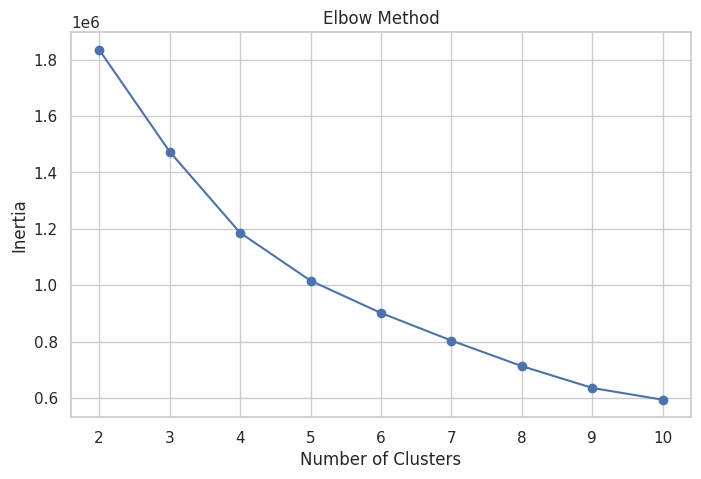

In [78]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(pca_features)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Clustering Models

In [79]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_df['KMeans_Cluster'] = kmeans.fit_predict(pca_features)

In [80]:
sample_size = min(5000, len(pca_features))
sample_idx = np.random.choice(len(pca_features), sample_size, replace=False)

dbscan = DBSCAN(eps=0.5, min_samples=20)
db_labels = dbscan.fit_predict(pca_features[sample_idx])

dbscan_labels_full = np.full(len(pca_features), -1)
dbscan_labels_full[sample_idx] = db_labels

# Evaluation

In [81]:
kmeans_sil = silhouette_score(
    pca_features,
    customer_df['KMeans_Cluster']
)

print("KMeans Silhouette Score:", kmeans_sil)

KMeans Silhouette Score: 0.24726097312809872


In [82]:
mask = dbscan_labels_full != -1
dbscan_sil = silhouette_score(
    pca_features[mask],
    dbscan_labels_full[mask]
)

print("DBSCAN Silhouette Score:", dbscan_sil)

DBSCAN Silhouette Score: 0.34358752970925266


# PCA Visualization

In [83]:
pca_vis = pd.DataFrame(
    pca_features[:, :2],
    columns=['PC1', 'PC2']
)

pca_vis['KMeans'] = customer_df['KMeans_Cluster']

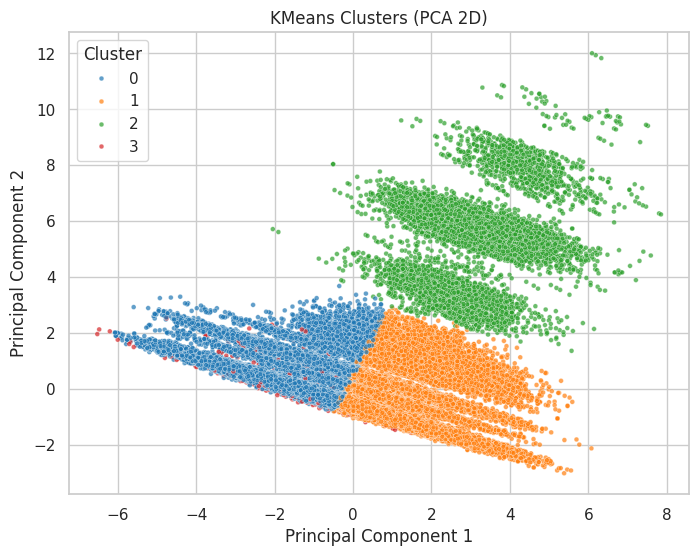

In [84]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_vis,
    x='PC1',
    y='PC2',
    hue='KMeans',
    palette='tab10',
    s=12,
    alpha=0.7
)

plt.title('KMeans Clusters (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

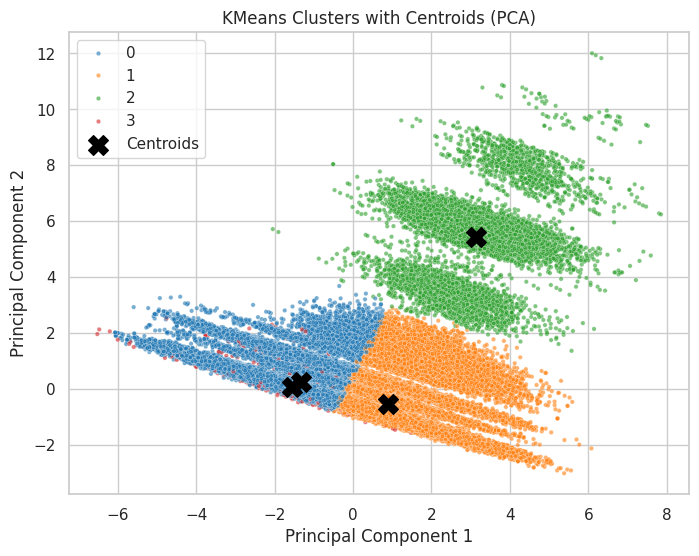

In [85]:
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_vis,
    x='PC1',
    y='PC2',
    hue='KMeans',
    palette='tab10',
    s=10,
    alpha=0.6
)

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='black',
    s=200,
    marker='X',
    label='Centroids'
)

plt.title('KMeans Clusters with Centroids (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

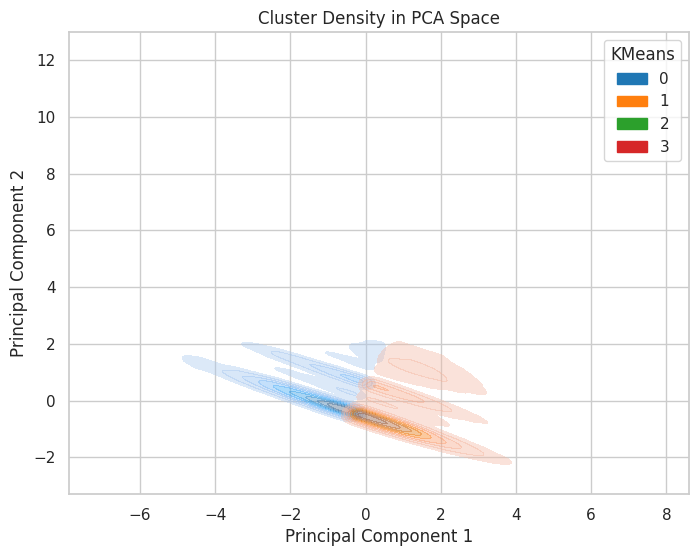

In [86]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=pca_vis,
    x='PC1',
    y='PC2',
    hue='KMeans',
    fill=True,
    alpha=0.4,
    palette='tab10'
)

plt.title('Cluster Density in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

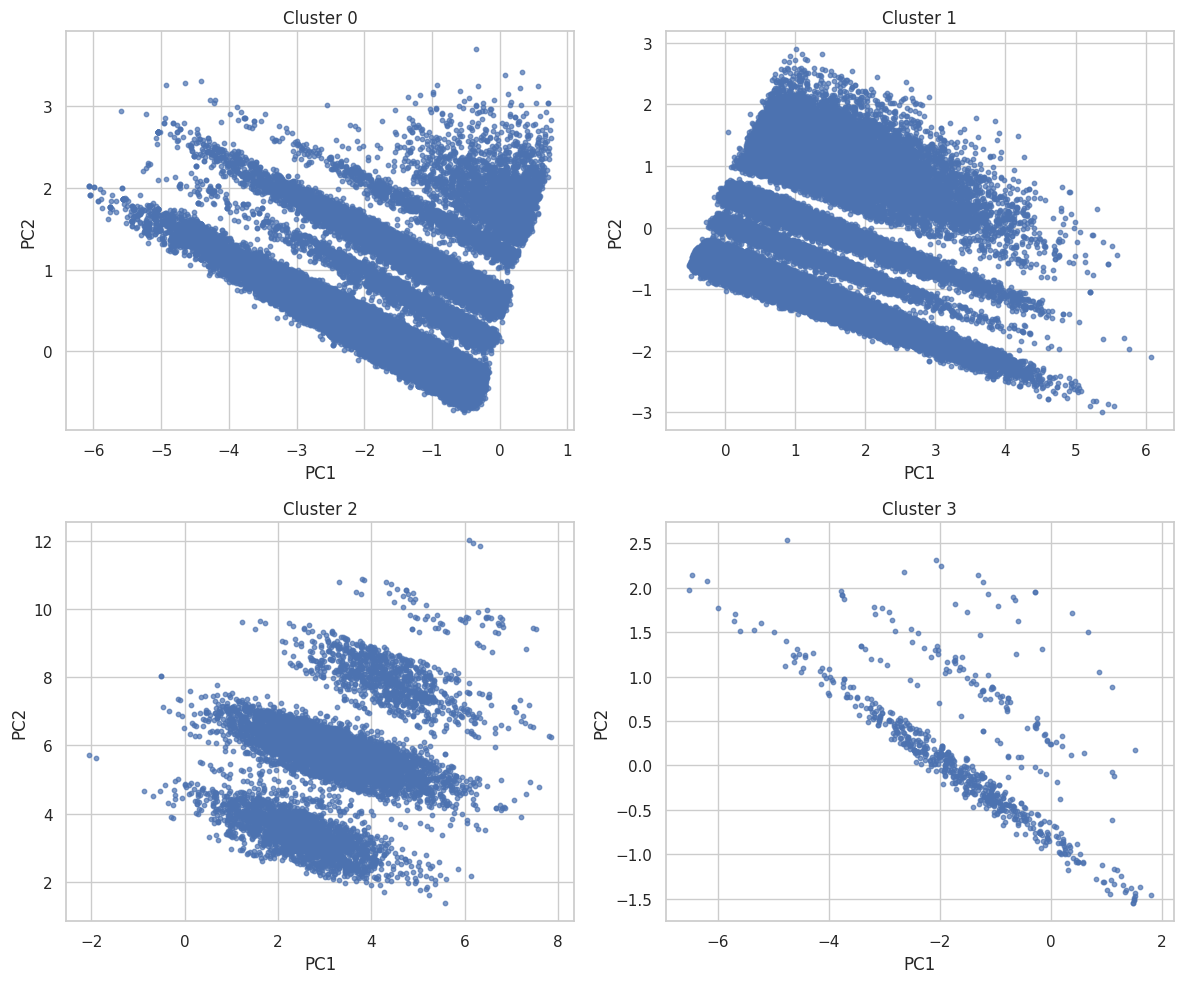

In [87]:
clusters = sorted(pca_vis['KMeans'].unique())

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    subset = pca_vis[pca_vis['KMeans'] == cluster]

    axes[i].scatter(
        subset['PC1'],
        subset['PC2'],
        s=10,
        alpha=0.7
    )

    axes[i].set_title(f'Cluster {cluster}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

plt.tight_layout()
plt.show()

# Cluster Profiling

In [88]:
cluster_profile = customer_df.groupby('KMeans_Cluster')[
    ['TotalAmount', 'AvgAccountBalance', 'Age']
].mean()

customer_df.groupby('KMeans_Cluster').size()

cluster_profile

,TotalAmount,AvgAccountBalance,Age
KMeans_Cluster,,,
0,197.023029,36171.700134,26.553002
1,2899.896416,168138.188437,29.739585
2,3264.803301,105696.851744,28.408451
3,2794.594217,1.409429,28.863836


# RFM Segmentation

In [89]:
rfm = customer_df[['CustomerID', 'Recency', 'TotalTransactions', 'TotalAmount']].copy()
rfm.columns = ['CustomerID', 'R', 'F', 'M']

In [90]:
rfm['R_Score'] = pd.qcut(rfm['R'].rank(method='first'), 4, labels=[4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['F'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['M'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)

In [91]:
rfm['RFM_Segment'] = rfm[['R_Score','F_Score','M_Score']].astype(str).agg(''.join, axis=1)

In [92]:
def rfm_segment_label(row):
    if row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'VIP'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 2:
        return 'Loyal'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 2:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost'
    else:
        return 'Regular'

rfm['RFM_Segment_Label'] = rfm.apply(rfm_segment_label, axis=1)

In [93]:
rfm.head(10)

,CustomerID,R,F,M,R_Score,F_Score,M_Score,RFM_Segment,RFM_Segment_Label
0,C1010011,25,2,5106.0,4,4,4,444,VIP
1,C1010011,25,2,5106.0,4,4,4,444,VIP
2,C1010014,75,2,1455.0,3,4,4,344,VIP
3,C1010014,75,2,1455.0,3,4,4,344,VIP
4,C1010031,78,2,1864.0,2,4,4,244,At Risk
5,C1010031,78,2,1864.0,2,4,4,244,At Risk
6,C1010035,81,1,50.0,1,1,1,111,Lost
7,C1010037,73,1,19680.0,3,1,4,314,Regular
8,C1010041,76,1,2397.0,2,1,4,214,Lost
9,C1010064,77,1,3000.0,2,1,4,214,Lost


# Visualization of Clusters

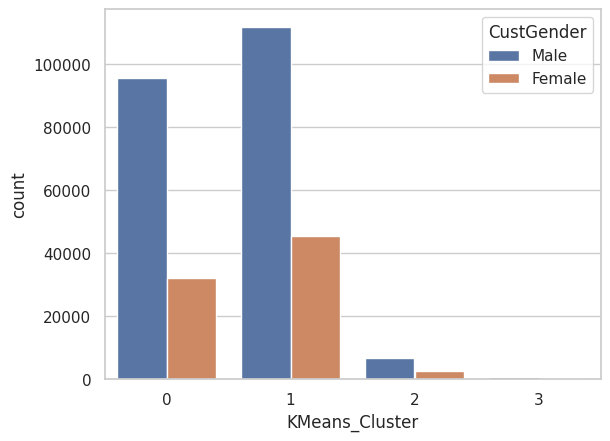

In [94]:
sns.countplot(
    x='KMeans_Cluster',
    hue='CustGender',
    data=customer_df
)
plt.show()

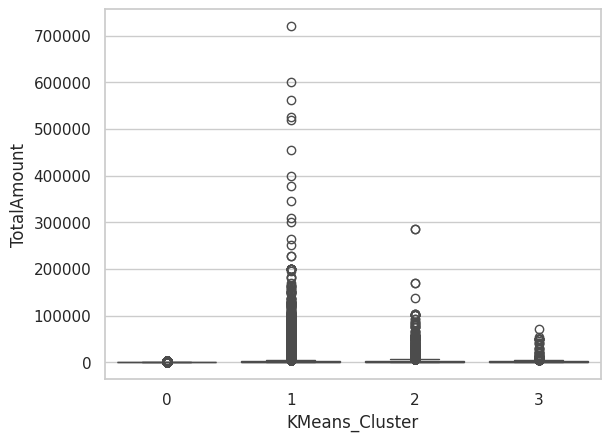

In [95]:
sns.boxplot(
    x='KMeans_Cluster',
    y='TotalAmount',
    data=customer_df
)
plt.show()

## Business Interpretation

High Value Cluster: Low Recency, High Monetary → VIP Customers

Dormant Cluster: High Recency → Re-engagement campaigns

Low Balance Cluster: ZeroBalanceRatio ↑ → Risk customers

ML vs RFM

RFM: Simple, interpretable, business-friendly

ML Clustering: Captures hidden patterns & multi-dimensional behavior

# Best Practice: Use RFM for business rules + ML for discovery

## Final Outcome

Clean & scalable notebook

PCA + Feature Selection

3 Clustering Models

RFM vs ML Comparison

Production-ready project